In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


##############################################
learning_rate = 0.1  # initial learning rate
min_learning_rate = 0.00001  # once the learning rate reaches this value, do not decrease it further
learning_rate_reduction_factor = 0.5  # the factor used when reducing the learning rate -> learning_rate *= learning_rate_reduction_factor
patience = 3  # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1  # controls the amount of logging done during training and testing: 0 - none, 1 - reports metrics after each batch, 2 - reports metrics after each epoch
image_size = (100, 100)  # width and height of the used images
input_shape = (100, 100, 3)  # the expected input shape for the trained models; since the images in the Fruit-360 are 100 x 100 RGB images, this is the required input shape

use_label_file = False  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = '../..'  # relative path to the Fruit-Images-Dataset folder
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')
output_dir = 'output_files'  # root folder in which to save the the output files; the files will be under output_files/model_name 
##############################################

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
num_classes = len(labels)

# create 2 charts, one for accuracy, one for loss, to show the evolution of these two metrics during the training process
def plot_model_history(model_history, out_path=""):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['acc']) + 1), model_history.history['acc'])
    axs[0].plot(range(1, len(model_history.history['val_acc']) + 1), model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['acc']) + 1), len(model_history.history['acc']))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    axs[1].legend(['train', 'val'], loc='best')
    # save the graph in a file called "acc_loss.png" to be available for later; the model_name is provided when creating and training a model
    if out_path:
        plt.savefig(out_path + "/acc_loss.png")
    plt.show()


# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    return ax


# given the train and test folder paths and a validation to test ratio, this method creates three generators
#  - the training generator uses (100 - validation_percent) of images from the train set 
#    it applies random horizontal and vertical flips for data augmentation and generates batches randomly
#  - the validation generator uses the remaining validation_percent of images from the train set
#    does not generate random batches, as the model is not trained on this data
#    the accuracy and loss are monitored using the validation data so that the learning rate can be updated if the model hits a local optimum
#  - the test generator uses the test set without any form of augmentation
#    once the training process is done, the final values of accuracy and loss are calculated on this set
def build_data_generators(train_folder, test_folder, validation_percent, labels=None, image_size=(100, 100), batch_size=50):
    train_datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,  # randomly flip images
        validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

    test_datagen = ImageDataGenerator()

    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, subset='training', classes=labels)
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, subset='validation', classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    return train_gen, validation_gen, test_gen


# this method performs all the steps from data setup, training and testing the model and plotting the results
# the model is any trainable model; the input shape and output number of classes is dependant on the dataset used, in this case the input is 100x100 RGB images and the output is a softmax layer with 118 probabilities
# the name is used to save the classification report containing the f1 score of the model, the plots showing the loss and accuracy and the confusion matrix
# the batch size is used to determine the number of images passed through the network at once, the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
def train_and_evaluate_model(model, name="", epochs=25, batch_size=50, verbose=verbose, useCkpt=False):
    print(model.summary())
    model_out_dir = os.path.join(output_dir, name)
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
    if useCkpt:
        model.load_weights(model_out_dir + "/model.h5")

    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=0.1, labels=labels, image_size=image_size, batch_size=batch_size)
    optimizer = Adadelta(lr=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_acc', verbose=verbose, 
                                 save_best_only=True, save_weights_only=False, mode='max', period=1)
    
    history = model.fit_generator(generator=trainGen,
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model])

    model.load_weights(model_out_dir + "/model.h5")

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate_generator(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    loss, accuracy = model.evaluate_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))
    plot_model_history(history, out_path=model_out_dir)
    testGen.reset()
    y_pred = model.predict_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    y_true = testGen.classes[testGen.index_array]
    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=model_out_dir)
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

    with open(model_out_dir + "/classification_report.txt", "w") as text_file:
        text_file.write("%s" % class_report)
    # print(class_report)


print(labels)
print(num_classes)

## Fruit Network

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda


# Create a custom layer that converts the original image from 
# RGB to HSV and grayscale and concatenates the results
# forming in input of size 100 x 100 x 4 
def image_process(x):
    import tensorflow as tf
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez


def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(image_process)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez


model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="fruit-360 model")

## AlexNet

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 100, 100, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 23, 23, 96)        34944     
_________________________________________________________________
conv1_relu (Activation)      (None, 23, 23, 96)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 11, 11, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 256)         614656    
_________________________________________________________________
conv2_relu (Activation)      (None, 7, 7, 256)         0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 3, 3, 256)         0   

1108/1108 [==============================] - 123s 111ms/step - loss: 4.8172e-05 - acc: 1.0000 - val_loss: 0.0737 - val_acc: 0.9877

Epoch 00023: val_acc did not improve from 0.98840
Epoch 24/25
1108/1108 [==============================] - 124s 112ms/step - loss: 6.2830e-05 - acc: 1.0000 - val_loss: 0.0720 - val_acc: 0.9873

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0015625000232830644.

Epoch 00024: val_acc did not improve from 0.98840
Epoch 25/25
1108/1108 [==============================] - 124s 112ms/step - loss: 6.2214e-05 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 0.9881

Epoch 00025: val_acc did not improve from 0.98840
413/413 [==============================] - 20s 48ms/step
Validation: accuracy = 0.988725  ;  loss_v = 0.059209
Test: accuracy = 0.978130  ;  loss_v = 0.125728


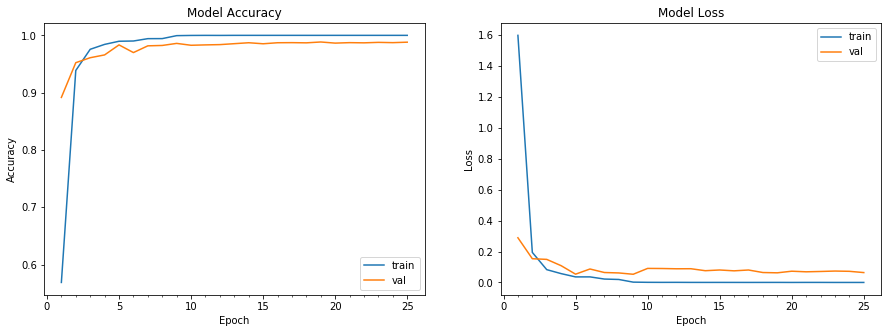

413/413 [==============================] - 13s 31ms/step


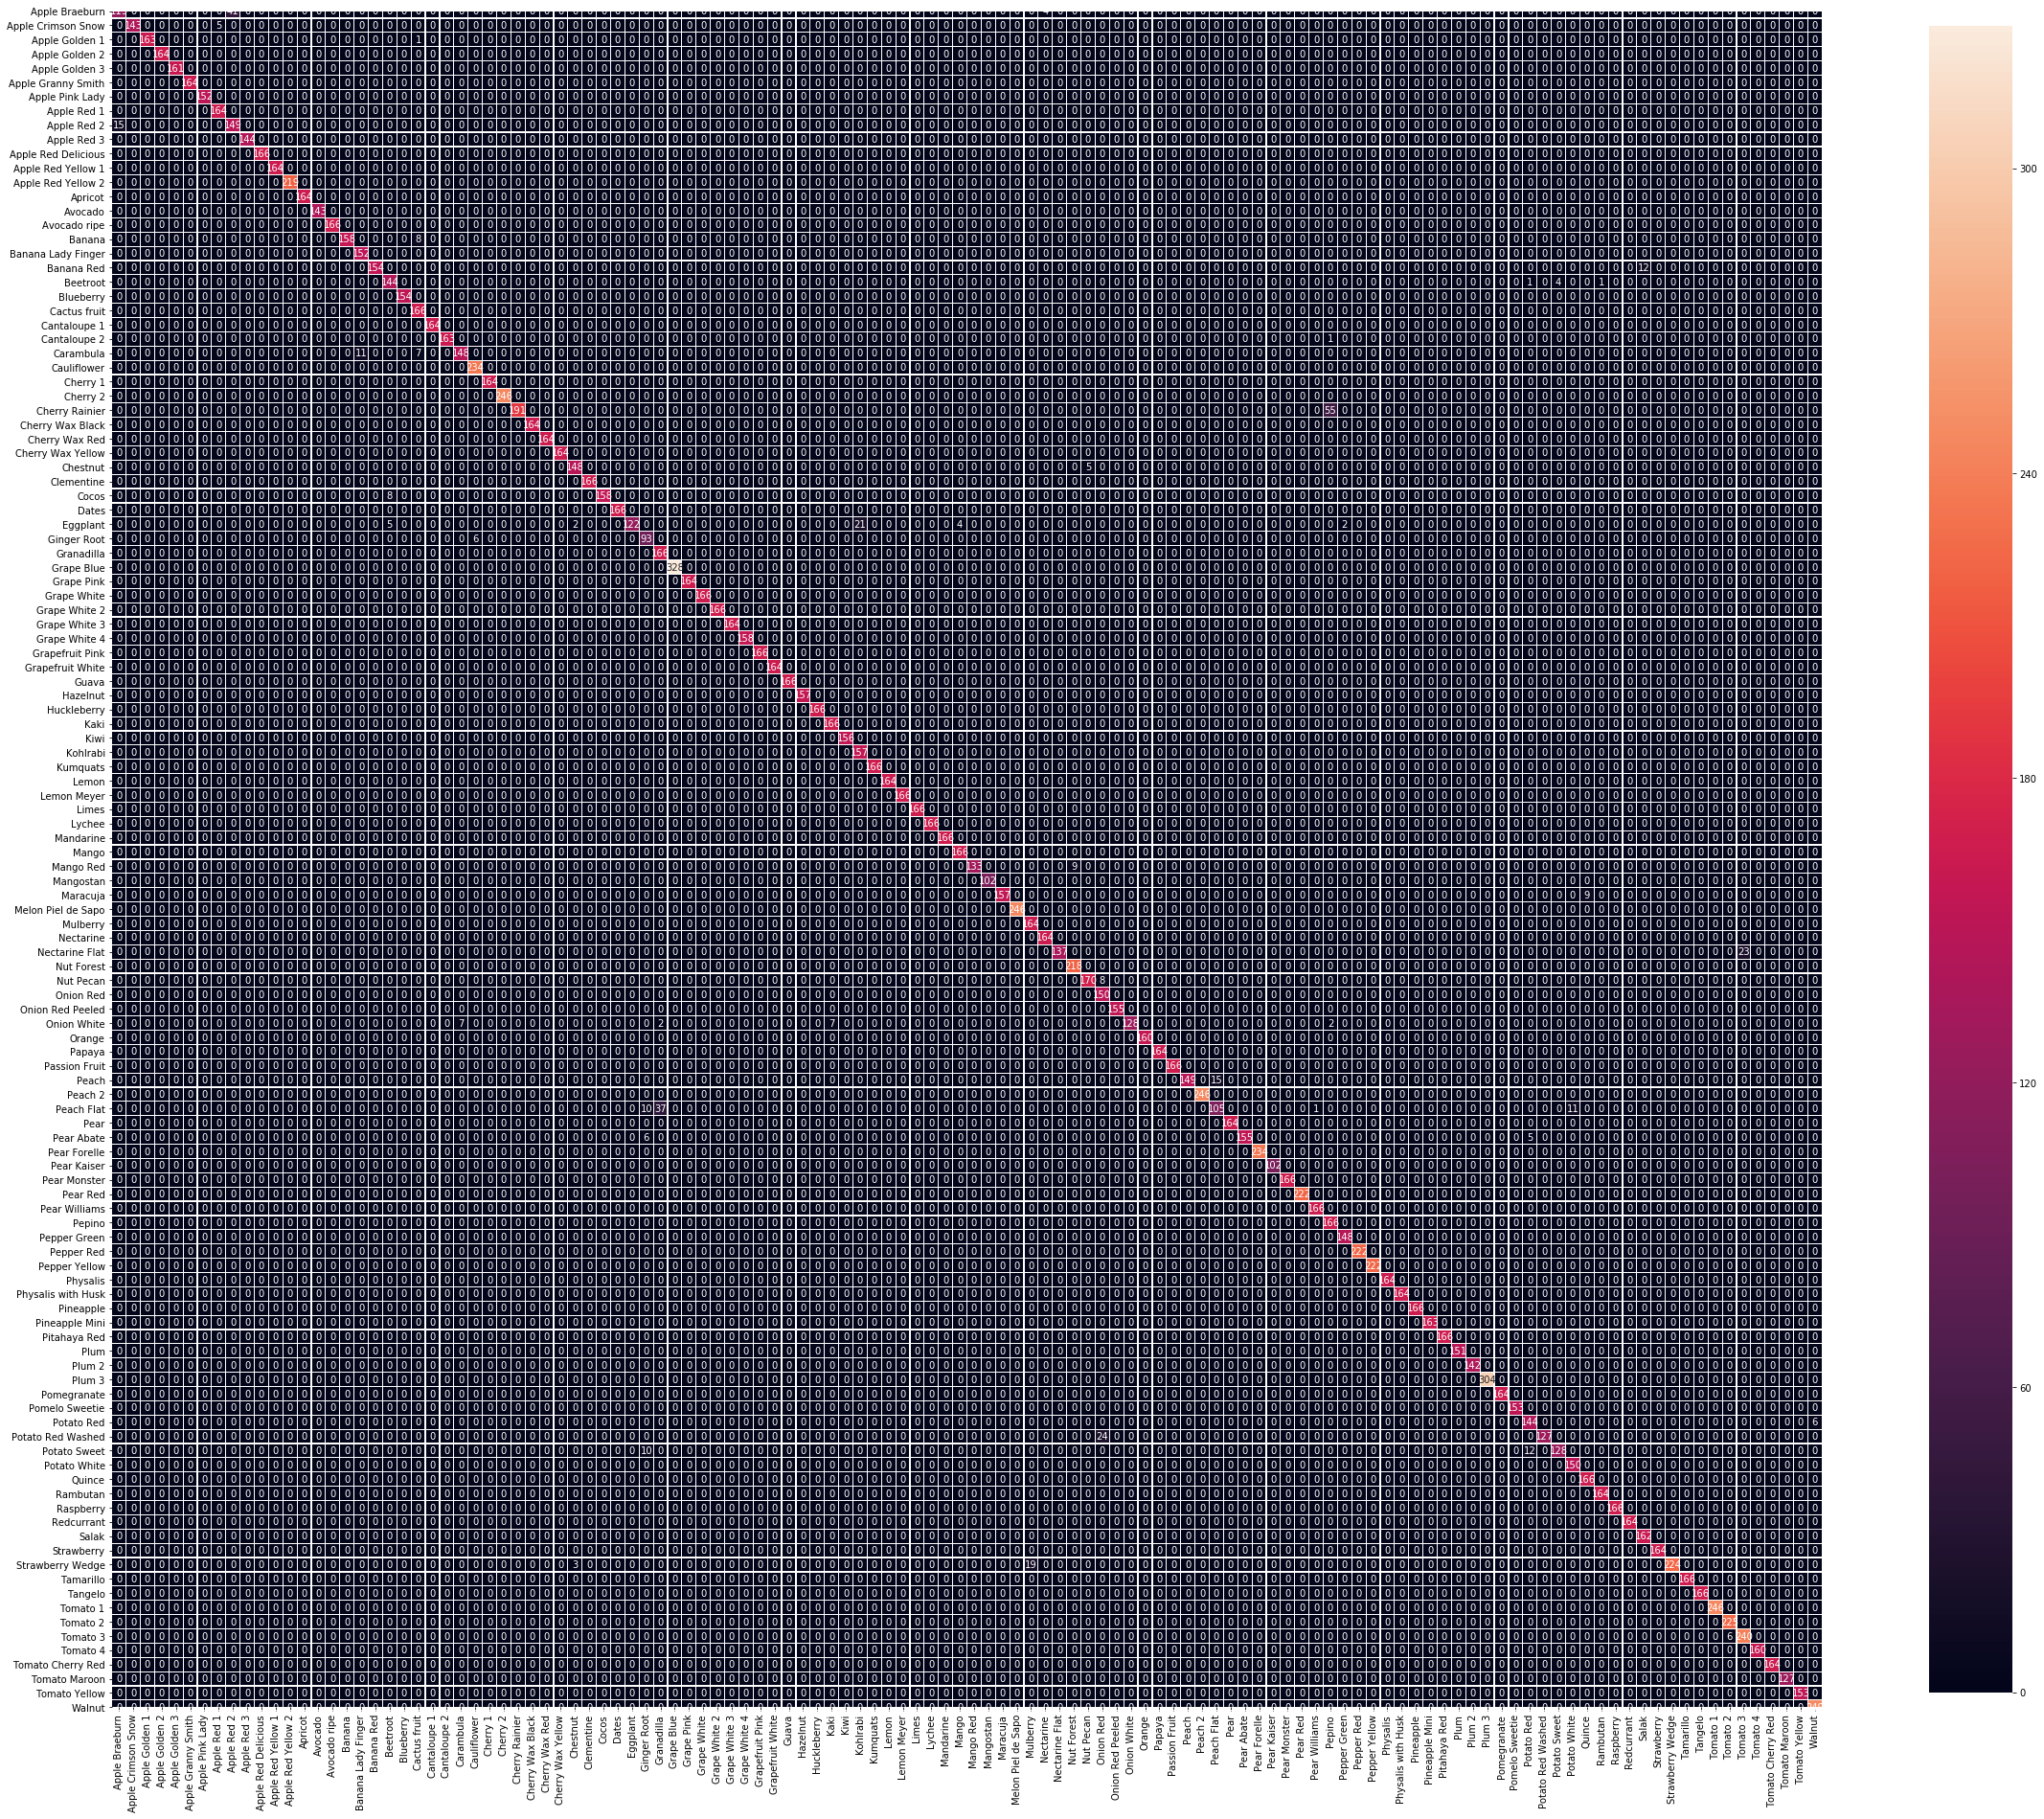

In [3]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout

def alexnet_model(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(96, (11, 11), strides=(4, 4), name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(256, (5, 5), strides=(1, 1), name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(384, (3, 3), strides=(1, 1), padding='same',name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = Conv2D(384, (3, 3), strides=(1, 1), padding='same',name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same',name='conv5')(x)
    x = Activation('relu', name='conv5_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu', name='fcl1')(x)
    x = Dropout(0.4)(x)
    x = Dense(4096, activation='relu', name='fcl2')(x)
    x = Dropout(0.4)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input,outputs=out)
    return rez


alexnet_model = alexnet_model(input_shape=(100, 100, 3), num_classes=num_classes)
train_and_evaluate_model(alexnet_model, name="alex_net")

## ZFNet

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization


def zfnet_model(input_shape, num_classes):
    img_input = Input(shape=input_shape)
    x = Conv2D(96, (7, 7), strides=(2, 2), name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool1')(x)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Conv2D(256, (5, 5), strides=(4, 4), name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool2')(x)
    x = BatchNormalization(axis=3, name='bn_conv2')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv5')(x)
    x = Activation('relu', name='conv5_relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='pool3')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu', name='fcl1')(x)
    x = Dense(4096, activation='relu', name='fcl2')(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input,outputs=out)
    return rez


zfnet_model = zfnet_model(input_shape=(100, 100, 3), num_classes=num_classes)
train_and_evaluate_model(zfnet_model, name="zf_net")

## VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
vgg16_model = VGG16(include_top=True, weights=None, input_shape=(100, 100, 3), classes=num_classes)
train_and_evaluate_model(vgg16_model, name="vgg16")

## VGG19

In [ ]:
from keras.applications.vgg19 import VGG19
vgg19_model = VGG19(include_top=True, weights=None, input_shape=(100, 100, 3), classes=num_classes)
train_and_evaluate_model(vgg19_model, name="vgg19")

## Inception V3

In [ ]:
from keras.applications import InceptionV3
inceptionV3_model = InceptionV3(include_top=True, weights=None, input_shape=(100, 100, 3), classes=num_classes)
train_and_evaluate_model(inceptionV3_model, name="inceptionV3")

## ResNet50

In [ ]:
from keras.applications import ResNet50
resNet50_model = ResNet50(include_top=True, weights=None, input_shape=(100, 100, 3), classes=num_classes)
train_and_evaluate_model(resNet50_model, name="resNet50")

## ResNet152

In [ ]:
from keras.applications import ResNet152
ResNet152_model = ResNet152(include_top=True, weights=None, input_shape=(100, 100, 3), classes=num_classes)
train_and_evaluate_model(ResNet152_model, name="resNet152", batch_size=10, useCkpt=True, epochs=18)

## InceptionResNetV2

In [ ]:
from keras.applications import InceptionResNetV2
InceptionResNetV2_model = InceptionResNetV2(include_top=True, weights=None, input_shape=(100, 100, 3), classes=num_classes)
train_and_evaluate_model(InceptionResNetV2_model, name="inceptionResNetV2", batch_size=10)
